# 클러스터링 분석

## K-means, GMM, Spectral, HDBSCAN 클러스터링 적용

## XAI 해석 (SHAP, LIME, Permutation Importance 적용)

### 사용할 라이브러리

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

In [2]:
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns

/Users/sungsupark/Desktop/2025-1 수업자료/소프트웨어융합캡스톤디자인/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# macOS에서 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스(-)가 깨질 수 있는 것을 방지함
plt.rcParams['axes.unicode_minus'] = False


### 데이터 불러오기 (window별 데이터)

In [4]:
# 절대경로로 불러옴
df_2020_2022 = pd.read_csv("/Users/sungsupark/Desktop/2025-1 수업자료/소프트웨어융합캡스톤디자인/csv/financial_data_window_2020_2022.csv")
df_2021_2023 = pd.read_csv("/Users/sungsupark/Desktop/2025-1 수업자료/소프트웨어융합캡스톤디자인/csv/financial_data_window_2021_2023.csv")
df_2022_2024 = pd.read_csv("/Users/sungsupark/Desktop/2025-1 수업자료/소프트웨어융합캡스톤디자인/csv/financial_data_window_2022_2024.csv")

# 기업명을 따로 저장한 후, feature만 따로 분리함
company_2020_2022 = df_2020_2022['기업명_그룹']
company_2021_2023 = df_2021_2023['기업명_그룹']
company_2022_2024 = df_2022_2024['기업명_그룹']
X_raw_2020_2022 = df_2020_2022.drop(columns=["기업명_그룹"])
X_raw_2021_2023 = df_2021_2023.drop(columns=["기업명_그룹"])
X_raw_2022_2024 = df_2022_2024.drop(columns=["기업명_그룹"])

X_raw_2020_2022

,매출액,영업이익,당기순이익,자산총계,자본총계,자본금,영업활동현금흐름,이자발생부채,영업이익률,순이익률,ROE(%),ROA(%),부채비율,EPS(원),PER(배),BPS(원),PBR(배),발행주식수(보통주)
0,70985.166667,2197.000000,1664.000000,2.733767e+04,8672.000000,173.0,5791.166667,7519.166667,3.071667,2.326667,20.556667,6.370000,216.680000,9629.666667,18.258333,50201.166667,3.486667,17283906.0
1,65153.666667,10667.500000,7884.333333,1.302548e+06,104070.666667,16297.0,13934.833333,188141.666667,16.550000,12.281667,8.033333,0.630000,1150.475000,2278.500000,3.096667,29234.333333,0.236667,325935246.0
2,372903.000000,19360.833333,6464.000000,4.477637e+05,169206.666667,1790.0,36457.000000,181936.166667,5.175000,1.726667,4.171667,1.501667,164.290000,5808.000000,17.345000,150724.833333,0.565000,29176998.0
3,116434.333333,3747.500000,1749.333333,9.451867e+04,40292.666667,1141.0,5215.333333,32803.333333,3.213333,1.496667,3.723333,1.875000,134.561667,5678.333333,28.503333,176992.666667,0.658333,22812344.0
4,278437.666667,15670.833333,8298.833333,2.822718e+05,110611.666667,819.0,17094.166667,106516.166667,5.633333,3.008333,10.466667,3.048333,154.990000,37635.166667,10.200000,392853.166667,0.983333,15054186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,169082.333333,11569.000000,8470.166667,4.893132e+05,72241.666667,447.0,9939.333333,11728.833333,7.235000,5.293333,13.046667,1.703333,665.428333,9474.166667,3.616667,91999.166667,0.303333,89400000.0
187,42520.500000,478.666667,-632.833333,2.837017e+04,5662.000000,2000.0,1157.333333,16159.000000,0.873333,-1.751667,-9.115000,-2.041667,402.983333,-1582.166667,3.356680,14950.833333,5.455000,39248121.0
188,32839.500000,1189.833333,368.333333,4.304900e+04,10586.666667,466.0,677.500000,14398.833333,3.580000,1.130000,2.238333,0.911667,305.755000,2210.333333,34.394582,101515.833333,0.678333,9324548.0
189,81669.500000,5808.000000,3736.166667,4.139467e+04,14648.500000,216.0,4552.666667,14565.000000,7.075000,4.560000,30.030000,10.281667,193.871667,65943.333333,67.425000,274582.666667,1.400000,4327682.0


### featurer scaling 수행

In [ ]:
# StandardScaler로 정규화한다.
scaler = StandardScaler()
X_scaled_2020_2022 = scaler.fit_transform(X_raw_2020_2022)
X_scaled_2021_2023 = scaler.fit_transform(X_raw_2021_2023)
X_scaled_2022_2024 = scaler.fit_transform(X_raw_2022_2024)
# X_scaled 데이터를 DataFrame으로 변환
X_scaled_df_2020_2022 = pd.DataFrame(X_scaled_2020_2022, columns=X_raw_2020_2022.columns)
X_scaled_df_2021_2023 = pd.DataFrame(X_scaled_2021_2023, columns=X_raw_2021_2023.columns)
X_scaled_df_2022_2024 = pd.DataFrame(X_scaled_2022_2024, columns=X_raw_2022_2024.columns)

# CSV 파일로 저장
X_scaled_df_2020_2022.to_csv("X_scaled_2020_2022.csv", index=False, encoding="utf-8-sig")
X_scaled_df_2021_2023.to_csv("X_scaled_2021_2023.csv", index=False, encoding="utf-8-sig")
X_scaled_df_2022_2024.to_csv("X_scaled_2022_2024.csv", index=False, encoding="utf-8-sig")

# print("X_scaled 데이터가 'X_scaled.csv'로 저장되었습니다.")

X_scaled 데이터가 'X_scaled.csv'로 저장되었습니다.


### 클러스터링 적용 및 평가 함수 정의

In [6]:
# 클러스터링 성능 평가 함수를 정의함 
# Silhouette Score를 사용함
def evaluate_clustering(model, X, labels=None):
    if (labels is None):
        labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    return labels, score

### ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

### 최적의 K 찾기 (2020-2022) - 그래프

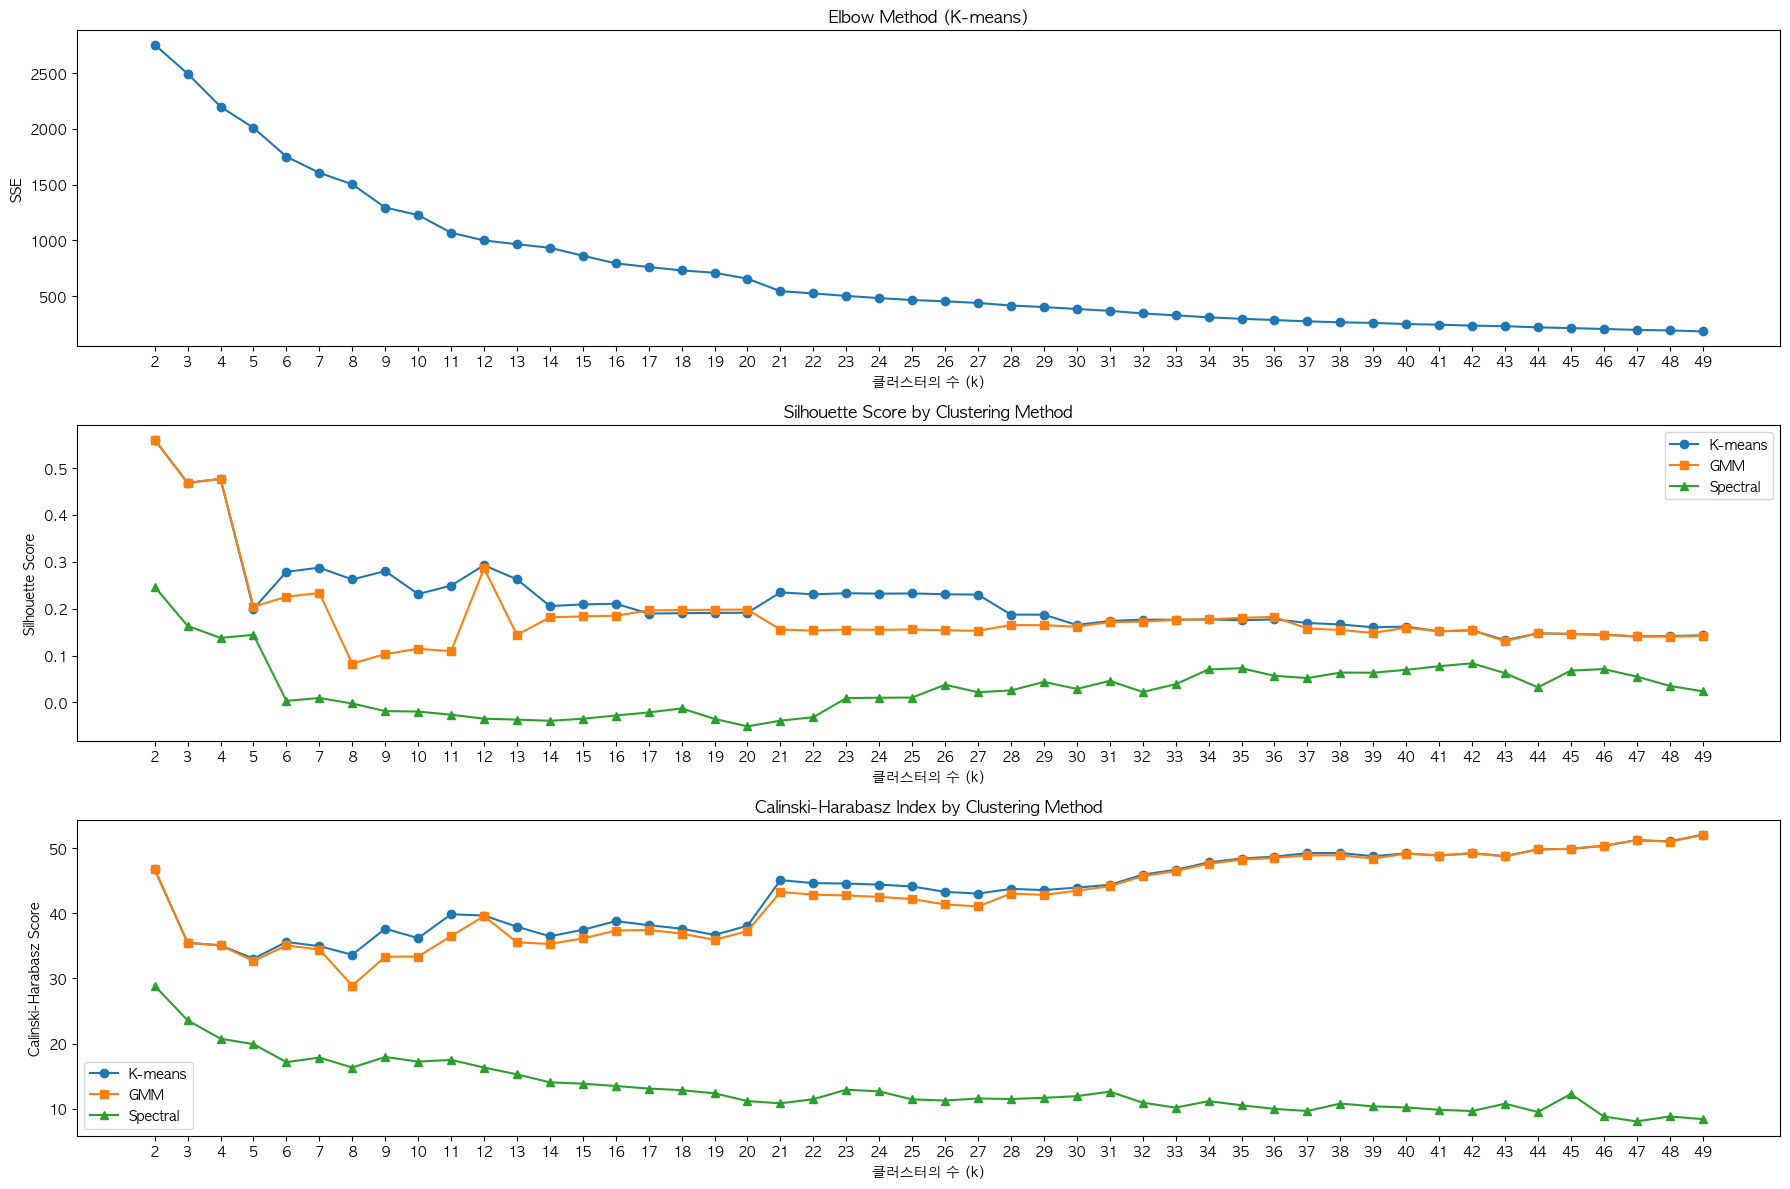

In [7]:
# 후보 K 값 범위 설정
k_values = range(2, 50)

# 결과 저장용 리스트
sse_list = [] # Elbow가 꺽이는 지점 확인용
silhouette_scores = [] # 실루엣 점수가 최대인 지점 확인용
ch_scores = [] # Calinski-Harabasz 점수가 최대인 지점 확인용

gmm_silhouette_scores = []
gmm_ch_scores = []

spectral_silhouette_scores = []
spectral_ch_scores = []

# 각 K에 대해 KMeans, GMM, Spectral 평가 (2020-2022)
for k in k_values:
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels_2020_2022 = kmeans.fit_predict(X_scaled_df_2020_2022)
    
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled_df_2020_2022, kmeans_labels_2020_2022))
    ch_scores.append(calinski_harabasz_score(X_scaled_df_2020_2022, kmeans_labels_2020_2022))
    
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels_2020_2022 = gmm.fit_predict(X_scaled_df_2020_2022)
    gmm_silhouette_scores.append(silhouette_score(X_scaled_df_2020_2022, gmm_labels_2020_2022))
    gmm_ch_scores.append(calinski_harabasz_score(X_scaled_df_2020_2022, gmm_labels_2020_2022))
    
    # Spectral clustering
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')
    spectral_labels_2020_2022 = spectral.fit_predict(X_scaled_df_2020_2022)
    spectral_silhouette_scores.append(silhouette_score(X_scaled_df_2020_2022, spectral_labels_2020_2022))
    spectral_ch_scores.append(calinski_harabasz_score(X_scaled_df_2020_2022, spectral_labels_2020_2022))

plt.figure(figsize=(18, 12))

# SSE (K-means 전용)
plt.subplot(3, 1, 1)
plt.plot(k_values, sse_list, marker='o')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Elbow Method (K-means)")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("SSE")

# Silhouette Score
plt.subplot(3, 1, 2)
plt.plot(k_values, silhouette_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_silhouette_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_silhouette_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Silhouette Score by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Silhouette Score")
plt.legend()

# Calinski-Harabasz Index
plt.subplot(3, 1, 3)
plt.plot(k_values, ch_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_ch_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_ch_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Calinski-Harabasz Index by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.legend()

plt.tight_layout()
plt.show()


### 최적의 k 찾기 (2020-2022) - 그래프

Best K for KMeans (lowest DBI): 26 -> DBI = 0.6598
Best K for GMM (lowest DBI): 26 -> DBI = 0.6849
Best K for Spectral Clustering (lowest DBI): 29 -> DBI = 1.3716


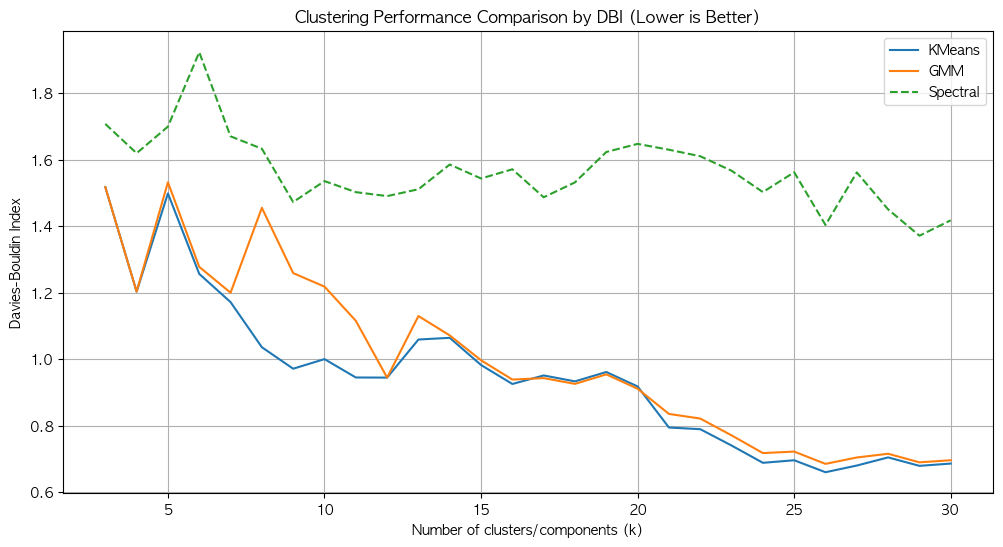

In [27]:
# 결과 저장
k_range = range(3, 31)

dbi_kmeans, dbi_gmm, dbi_spectral = [], [], []

labels_kmeans_all, labels_gmm_all, labels_spectral_all = {}, {}, {}

# 반복 수행
for k in k_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_labels_2020_2022 = kmeans.fit_predict(X_scaled_2020_2022)
    dbi_kmeans.append(davies_bouldin_score(X_scaled_df_2020_2022, kmeans_labels_2020_2022))
    labels_kmeans_all[k] = kmeans_labels_2020_2022

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels_2020_2022 = gmm.fit_predict(X_scaled_df_2020_2022)
    dbi_gmm.append(davies_bouldin_score(X_scaled_df_2020_2022, gmm_labels_2020_2022))
    labels_gmm_all[k] = gmm_labels_2020_2022

    # Spectral Clustering
    try:
        spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors', assign_labels='kmeans')
        spectral_labels_2020_2022 = spectral.fit_predict(X_scaled_df_2020_2022)
        dbi_spectral.append(davies_bouldin_score(X_scaled_df_2020_2022, spectral_labels_2020_2022))
        labels_spectral_all[k] = spectral_labels_2020_2022

    except Exception:
        # 실패한 경우 큰 값으로 대체 (e.g., affinity 문제 등)
        dbi_spectral.append(np.inf)
        labels_spectral_all[k] = None


# 가장 낮은 DBI를 보이는 k 찾기
best_k_kmeans = k_range[np.argmin(dbi_kmeans)]
best_k_gmm = k_range[np.argmin(dbi_gmm)]
best_k_spectral = k_range[np.argmin(dbi_spectral)]

# 결과 출력
print(f"Best K for KMeans (lowest DBI): {best_k_kmeans} -> DBI = {min(dbi_kmeans):.4f}")
print(f"Best K for GMM (lowest DBI): {best_k_gmm} -> DBI = {min(dbi_gmm):.4f}")
print(f"Best K for Spectral Clustering (lowest DBI): {best_k_spectral} -> DBI = {min(dbi_spectral):.4f}")

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(k_range, dbi_kmeans, label='KMeans')
plt.plot(k_range, dbi_gmm, label='GMM')
plt.plot(k_range, dbi_spectral, label='Spectral', linestyle='--')
plt.xlabel('Number of clusters/components (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Clustering Performance Comparison by DBI (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()


### K-means, GMM, Sperctral Clustering 적용 및 비교

In [ ]:
# Window 2020-2022

# K-means clustering
# K-means는 k=26에서 가장 높은 점수를 보임
kmeans = KMeans(n_clusters=26, random_state=42)
kmeans_labels_2020_2022, kmeans_score_2020_2022 = evaluate_clustering(kmeans, X_scaled_df_2020_2022)

# GMM
# GMM은 k=29에서 가장 높은 점수를 보임
gmm = GaussianMixture(n_components=26, random_state=42)
gmm_labels_2020_2022, gmm_score_2020_2022 = evaluate_clustering(gmm, X_scaled_df_2020_2022, labels=gmm.fit_predict(X_scaled_df_2020_2022))

# Spectral clustering
# Spectral clustering은 거의 모든 k의 범위에서 평가가 낮게 나옴
spectral = SpectralClustering(n_clusters=29, random_state=42, affinity='nearest_neighbors')
spectral_labels_2020_2022, spectral_score_2020_2022 = evaluate_clustering(spectral, X_scaled_df_2020_2022)


# Davies-Bouldin Index 계산
# 보통 0.5 ~ 1.0 사이면 괜찮은 클러스터링이라고 함. 실무에서 자주 나오는 수준
kmeans_dbi_2020_2022 = davies_bouldin_score(X_scaled_df_2020_2022, kmeans_labels_2020_2022)
gmm_dbi_2020_2022 = davies_bouldin_score(X_scaled_df_2020_2022, gmm_labels_2020_2022)
spectral_dbi_2020_2022 = davies_bouldin_score(X_scaled_df_2020_2022, spectral_labels_2020_2022)

# 결과 비교 출력
print(f"KMeans Davies-Bouldin Index: {kmeans_dbi_2020_2022:.4f}")
print(f"GMM Davies-Bouldin Index: {gmm_dbi_2020_2022:.4f}")
print(f"Spectral Davies-Bouldin Index: {spectral_dbi_2020_2022:.4f}")

# # 결과 비교
# print(f"KMeans Silhouette Score: {kmeans_score:.4f}")
# print(f"GMM Silhouette Score: {gmm_score:.4f}")
# print(f"Spectral Silhouette Score: {spectral_score:.4f}")


KMeans Davies-Bouldin Index: 0.6598
GMM Davies-Bouldin Index: 0.6849
Spectral Davies-Bouldin Index: 1.3716


### 최종적으로 선택한 클러스터 결과 저장 (K-means)

In [ ]:
# K-means가 0.6598로 값이 가장 낮게 나왔다.
df_2020_2022['Cluster'] = kmeans_labels_2020_2022

### Random Forest 학습 - XAI 해석용

In [30]:
# RandomForestClassifier 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators은 기본값으로 사용함
clf.fit(X_scaled_df_2020_2022, kmeans_labels_2020_2022)

RandomForestClassifier(random_state=42)

### SHAP 해석

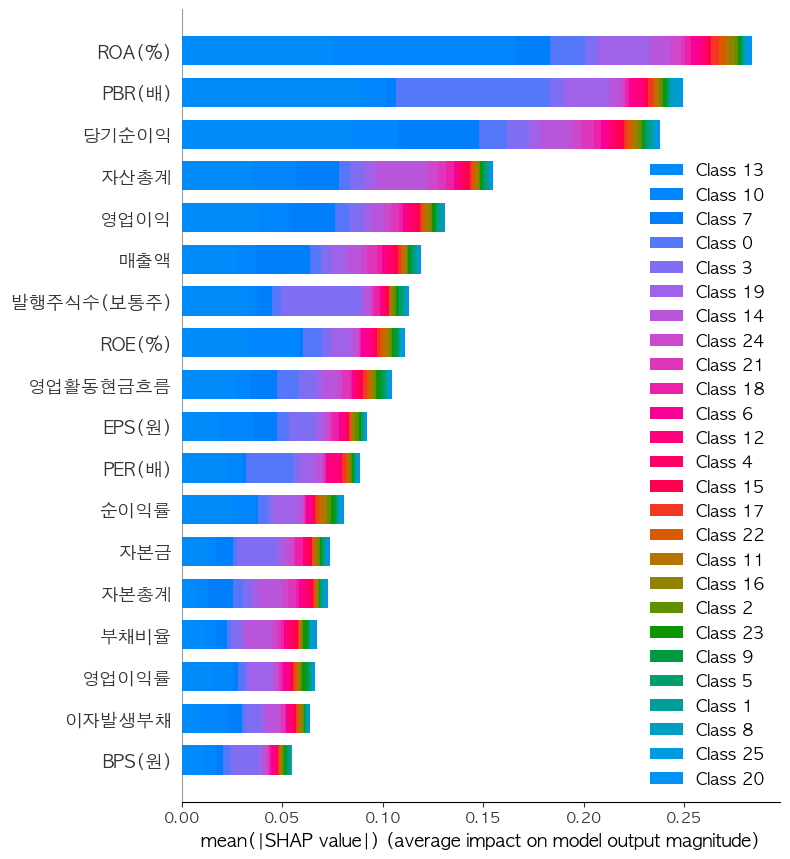

In [31]:
# SHAP 분석
explainer_2020_2022 = shap.TreeExplainer(clf)
shap_values_2020_2022 = explainer_2020_2022.shap_values(X_scaled_df_2020_2022)

# feature importance를 시각화함
shap.summary_plot(shap_values_2020_2022, X_raw_2020_2022, plot_type="bar")

In [32]:
# 클러스터별 SHAP 값의 평균 구하기
cluster_shap_means_2020_2022 = {}
for cluster_id in range(kmeans.n_clusters):
    # 현재 클러스터에 속한 인덱스 추출
    cluster_indices = np.where(kmeans_labels_2020_2022 == cluster_id)[0]
    
    # 해당 클러스터에 대한 SHAP 값만 선택
    cluster_shap_values = shap_values_2020_2022[cluster_indices]
    
    # SHAP 값의 절대값 평균 계산
    cluster_mean_shap = np.abs(cluster_shap_values).mean(axis=0)
    
    # 2차원 배열인 경우 1차원으로 변환 (첫 번째 차원만 사용하거나 적절히 처리)
    if len(cluster_mean_shap.shape) > 1:
        # 차원이 (14, 4)와 같이 2차원인 경우, 첫 번째 차원만 사용하거나 평탄화
        cluster_mean_shap = cluster_mean_shap.flatten() if cluster_mean_shap.size == len(X_raw_2020_2022.columns) else cluster_mean_shap[:, 0]
    
    # 결과 저장
    cluster_shap_means_2020_2022[cluster_id] = cluster_mean_shap

# 모든 클래스에 대한 특성 중요도를 DataFrame으로 변환
feature_importance_df = pd.DataFrame(index=X_raw_2020_2022.columns)

# 각 클래스별 중요도 추가
for cluster_id in range(kmeans.n_clusters):
    # cluster_shap_means[cluster_id]의 길이가 X_raw.columns와 일치하는지 확인
    if len(cluster_shap_means_2020_2022[cluster_id]) != len(X_raw_2020_2022.columns):
        print(f"경고: 클러스터 {cluster_id}의 SHAP 값 길이({len(cluster_shap_means_2020_2022[cluster_id])})가 특성 수({len(X_raw_2020_2022.columns)})와 일치하지 않습니다.")
        continue
    
    feature_importance_df[f'Class {cluster_id}'] = cluster_shap_means_2020_2022[cluster_id]

# 결과 출력 - 각 클래스별로 내림차순 정렬해서 보여주기
print("각 클래스별 특성 중요도 (SHAP 값 평균):")
print(feature_importance_df)

# 각 클래스별로 중요 특성 순위 확인
for cluster_id in range(kmeans.n_clusters):
    if f'Class {cluster_id}' not in feature_importance_df.columns:
        print(f"\nClass {cluster_id}에 대한 특성 중요도를 계산할 수 없습니다.")
        continue
        
    print(f"\nClass {cluster_id}에 중요한 특성 순위:")
    class_importance = feature_importance_df[f'Class {cluster_id}'].sort_values(ascending=False)
    for i, (feature, importance) in enumerate(class_importance.items(), 1):
        print(f"{i}. {feature}: {importance:.6f}")

각 클래스별 특성 중요도 (SHAP 값 평균):
             Class 0   Class 1   Class 2   Class 3   Class 4   Class 5  \
매출액         0.023667  0.008317  0.000433  0.004671  0.005918  0.006605   
영업이익        0.035235  0.007042  0.003966  0.004786  0.009651  0.002708   
당기순이익       0.061274  0.013555  0.001865  0.005087  0.012394  0.001153   
자산총계        0.021760  0.006603  0.000176  0.005207  0.008134  0.008988   
자본총계        0.014729  0.001053  0.002233  0.006451  0.001151  0.002992   
자본금         0.006987  0.002328  0.002936  0.004546  0.003000  0.005914   
영업활동현금흐름    0.037413  0.008867  0.001604  0.014259  0.008730  0.023712   
이자발생부채      0.007141  0.001208  0.000017  0.001990  0.001300  0.002227   
영업이익률       0.010576  0.000130  0.000631  0.002807  0.000447  0.004406   
순이익률        0.016912  0.001321  0.000140  0.002205  0.001018  0.000669   
ROE(%)      0.030279  0.002172  0.006828  0.005409  0.001863  0.001145   
ROA(%)      0.049447  0.005725  0.007173  0.007391  0.004398  0.000974   
부채비율       

### 위에 결과를 보면 각 class 별로 잘 주요한 feature가 나온 것을 확인할 수 있다.

### 각 cluster에 어떤 종목이 포함되어 있는지 확인

In [33]:
# 클러스터별 기업 리스트를 출력한다.
for cluster_id in range(kmeans.n_clusters):
    print(f"[클러스터 {cluster_id}에 속한 종목들]:")
    stock_list = company_2020_2022[kmeans_labels_2020_2022 == cluster_id].values
    print(", ".join(stock_list))


[클러스터 0에 속한 종목들]:
LG에너지솔루션, SK아이이테크놀로지, 대한전선, 두산퓨얼셀, 씨에스윈드, 엘앤에프, 일진하이솔루스, 카카오페이, 코스모신소재, 코스모화학, 포스코퓨처엠, 하이브, 한미사이언스, 한미약품, 한전기술, 호텔신라
[클러스터 1에 속한 종목들]:
현대차
[클러스터 2에 속한 종목들]:
태광산업
[클러스터 3에 속한 종목들]:
KT, LG디스플레이, LG유플러스, NH투자증권, 금호타이어, 대우건설, 대한항공, 두산에너빌리티, 삼성중공업, 카카오뱅크, 팬오션, 한온시스템
[클러스터 4에 속한 종목들]:
KB금융, 신한지주
[클러스터 5에 속한 종목들]:
한국전력
[클러스터 6에 속한 종목들]:
F&F, 에스디바이오센서
[클러스터 7에 속한 종목들]:
CJ, CJ제일제당, DB손해보험, GS, HD현대, LG전자, LG화학, S-Oil, SK이노베이션, SK텔레콤, 메리츠금융지주, 삼성SDI, 삼성물산, 삼성화재, 이마트, 현대모비스, 현대제철
[클러스터 8에 속한 종목들]:
하나투어
[클러스터 9에 속한 종목들]:
GKL
[클러스터 10에 속한 종목들]:
BGF리테일, KT&G, LG, LG생활건강, LG이노텍, LX인터내셔널, OCI홀딩스, SK케미칼, 고려아연, 금호석유화학, 동서, 롯데정밀화학, 미스토홀딩스, 삼성E&A, 삼성에스디에스, 삼성전기, 삼양식품, 세아제강지주, 영원무역, 영원무역홀딩스, 오뚜기, 오리온, 카카오, 코웨이, 현대글로비스, 효성티앤씨
[클러스터 11에 속한 종목들]:
한진칼
[클러스터 12에 속한 종목들]:
HS효성첨단소재, 한올바이오파마
[클러스터 13에 속한 종목들]:
CJ대한통운, DL, DL이앤씨, GS건설, GS리테일, HD한국조선해양, HD현대미포, HD현대인프라코어, HD현대일렉트릭, HL만도, KCC, KG모빌리티, LIG넥스원, LS, LS ELECTRIC, SKC, SK네트웍스, SK스퀘어, TCC스틸, TKG휴켐스, 강원랜드, 넷마블, 녹십자, 녹십자홀딩스, 농심, 대상, 대웅, 대웅제

### K-means 클러스터링 결과에 종목명을 포함해서 시각화

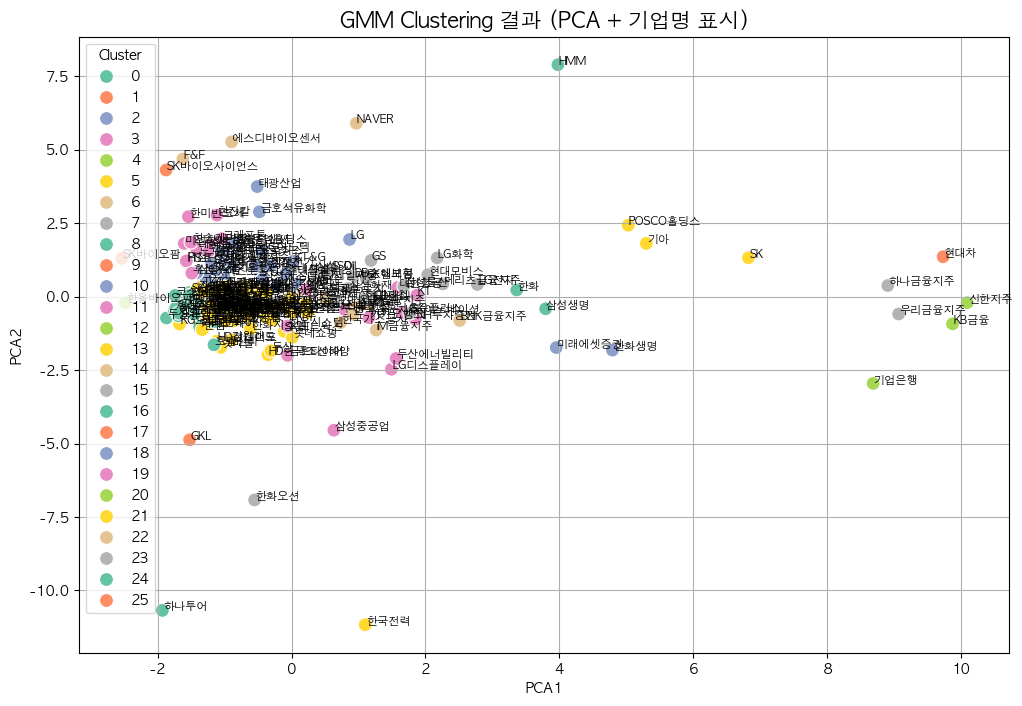

In [34]:
# 시각화를 위해 PCA로 차원을 축소한다.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_2020_2022)

# 결과를 dataFrame으로 정리한다. 
df_clustered = pd.DataFrame({
    '기업명': company_2020_2022.values,
    'Cluster': kmeans_labels_2020_2022,
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1]
})

# 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clustered, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
for i in range(df_clustered.shape[0]):
    plt.text(df_clustered['PCA1'][i]+0.01, df_clustered['PCA2'][i]+0.01, df_clustered['기업명'][i], fontsize=8)
plt.title("GMM Clustering 결과 (PCA + 기업명 표시)", fontsize=15)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

### ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

### 최적의 K 찾기 (2021-2023) - 그래프

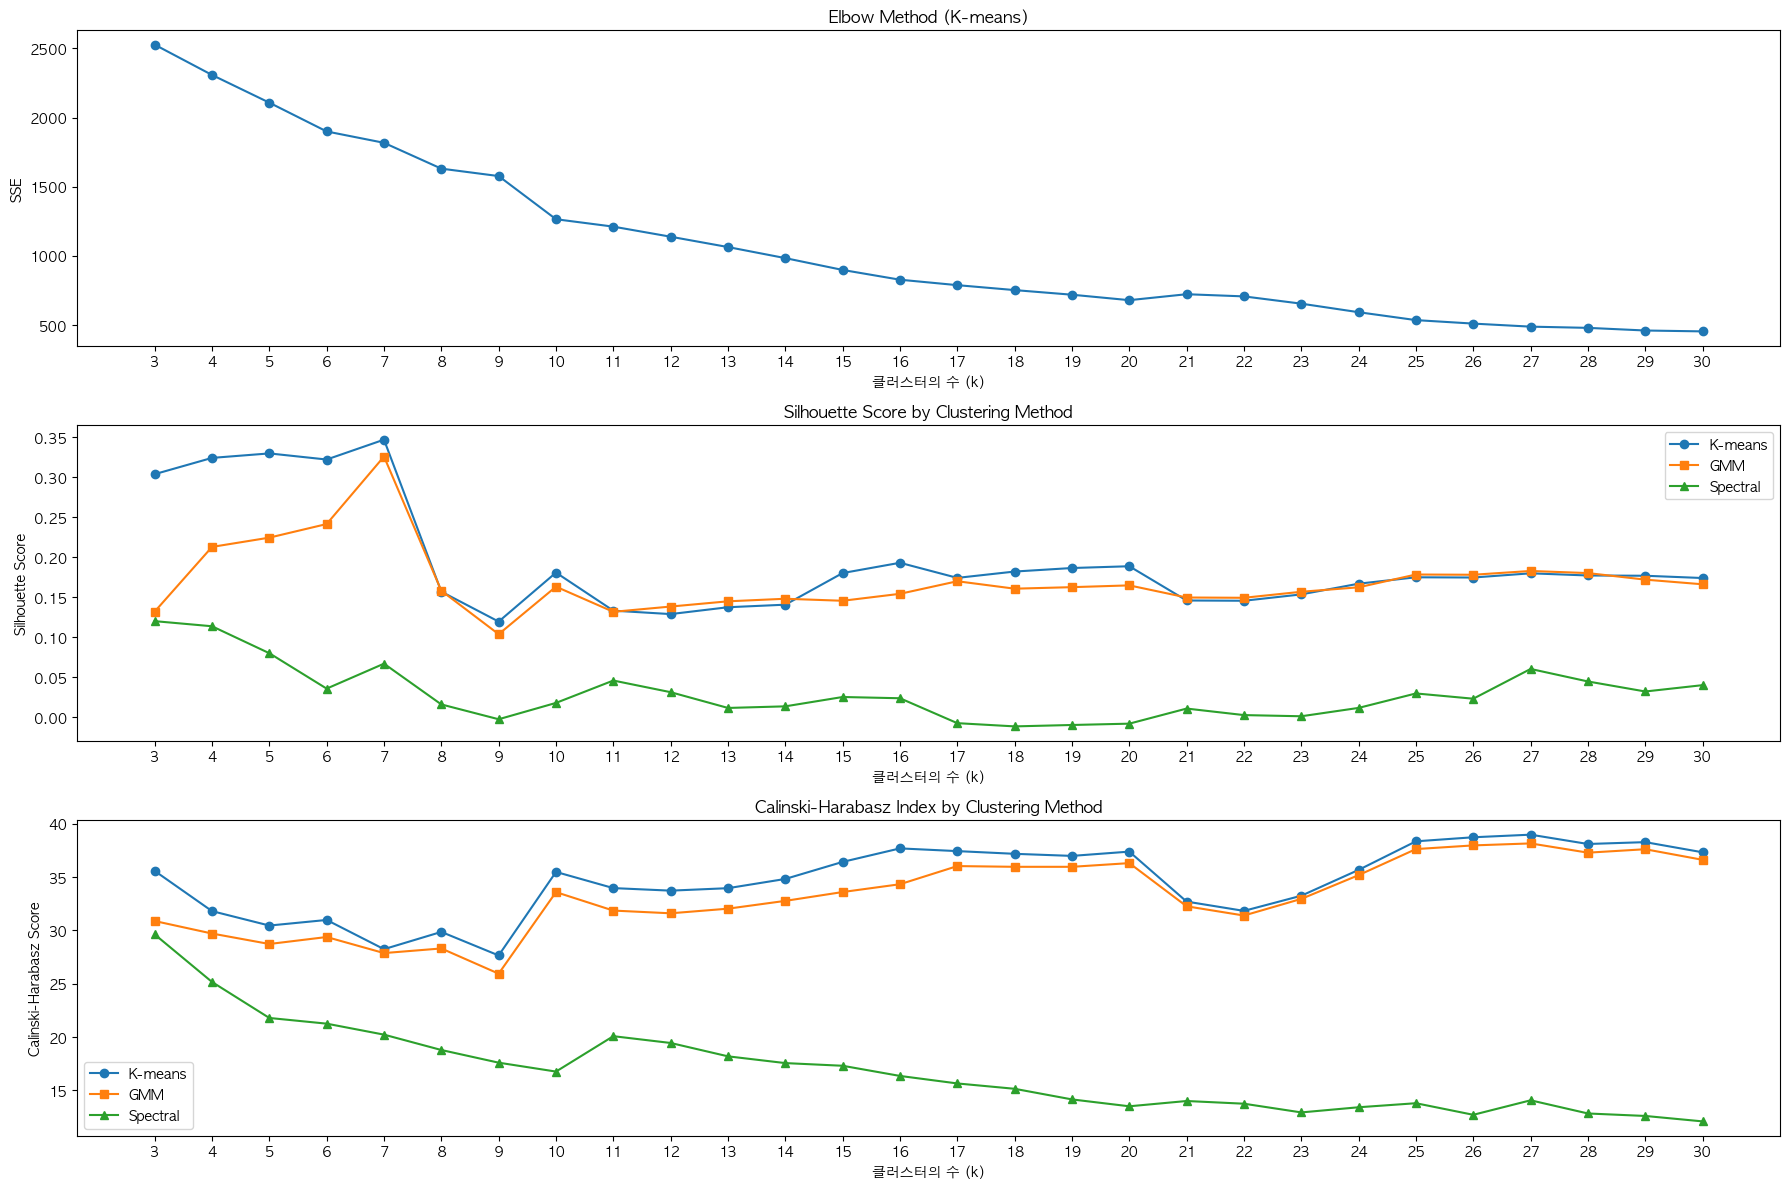

In [35]:
# 후보 K 값 범위 설정
k_values = range(3, 31)

# 결과 저장용 리스트
sse_list = [] # Elbow가 꺽이는 지점 확인용
silhouette_scores = [] # 실루엣 점수가 최대인 지점 확인용
ch_scores = [] # Calinski-Harabasz 점수가 최대인 지점 확인용

gmm_silhouette_scores = []
gmm_ch_scores = []

spectral_silhouette_scores = []
spectral_ch_scores = []

# 각 K에 대해 KMeans, GMM, Spectral 평가 (2020-2022)
for k in k_values:
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels_2021_2023 = kmeans.fit_predict(X_scaled_df_2021_2023)
    
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled_df_2021_2023, kmeans_labels_2021_2023))
    ch_scores.append(calinski_harabasz_score(X_scaled_df_2021_2023, kmeans_labels_2021_2023))
    
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels_2021_2023 = gmm.fit_predict(X_scaled_df_2021_2023)
    gmm_silhouette_scores.append(silhouette_score(X_scaled_df_2021_2023, gmm_labels_2021_2023))
    gmm_ch_scores.append(calinski_harabasz_score(X_scaled_df_2021_2023, gmm_labels_2021_2023))
    
    # Spectral clustering
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')
    spectral_labels_2021_2023 = spectral.fit_predict(X_scaled_df_2021_2023)
    spectral_silhouette_scores.append(silhouette_score(X_scaled_df_2021_2023, spectral_labels_2021_2023))
    spectral_ch_scores.append(calinski_harabasz_score(X_scaled_df_2021_2023, spectral_labels_2021_2023))

plt.figure(figsize=(18, 12))

# SSE (K-means 전용)
plt.subplot(3, 1, 1)
plt.plot(k_values, sse_list, marker='o')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Elbow Method (K-means)")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("SSE")

# Silhouette Score
plt.subplot(3, 1, 2)
plt.plot(k_values, silhouette_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_silhouette_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_silhouette_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Silhouette Score by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Silhouette Score")
plt.legend()

# Calinski-Harabasz Index
plt.subplot(3, 1, 3)
plt.plot(k_values, ch_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_ch_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_ch_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Calinski-Harabasz Index by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.legend()

plt.tight_layout()
plt.show()


### 최적의 K 찾기 (2021-2023) - 자동화

Best K for KMeans (lowest DBI): 28 -> DBI = 0.6626
Best K for GMM (lowest DBI): 28 -> DBI = 0.6661
Best K for Spectral Clustering (lowest DBI): 27 -> DBI = 1.3660


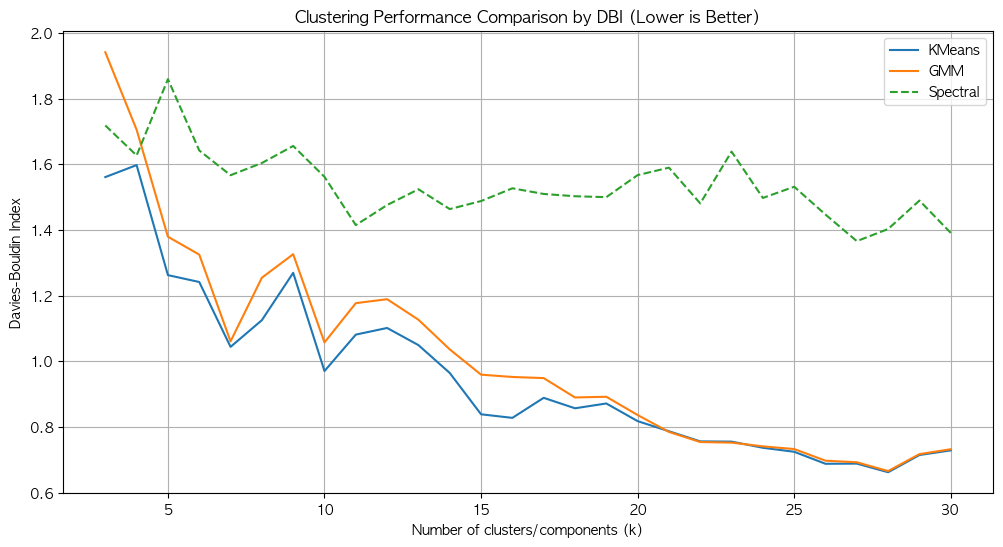

In [36]:
# 결과 저장
k_range = range(3, 31)

dbi_kmeans, dbi_gmm, dbi_spectral = [], [], []

labels_kmeans_all, labels_gmm_all, labels_spectral_all = {}, {}, {}

# 반복 수행
for k in k_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_labels_2021_2023 = kmeans.fit_predict(X_scaled_2021_2023)
    dbi_kmeans.append(davies_bouldin_score(X_scaled_df_2021_2023, kmeans_labels_2021_2023))
    labels_kmeans_all[k] = kmeans_labels_2021_2023

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels_2021_2023 = gmm.fit_predict(X_scaled_df_2021_2023)
    dbi_gmm.append(davies_bouldin_score(X_scaled_df_2021_2023, gmm_labels_2021_2023))
    labels_gmm_all[k] = gmm_labels_2021_2023

    # Spectral Clustering
    try:
        spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors', assign_labels='kmeans')
        spectral_labels_2021_2023 = spectral.fit_predict(X_scaled_df_2021_2023)
        dbi_spectral.append(davies_bouldin_score(X_scaled_df_2021_2023, spectral_labels_2021_2023))
        labels_spectral_all[k] = spectral_labels_2021_2023

    except Exception:
        # 실패한 경우 큰 값으로 대체 (e.g., affinity 문제 등)
        dbi_spectral.append(np.inf)
        labels_spectral_all[k] = None


# 가장 낮은 DBI를 보이는 k 찾기
best_k_kmeans = k_range[np.argmin(dbi_kmeans)]
best_k_gmm = k_range[np.argmin(dbi_gmm)]
best_k_spectral = k_range[np.argmin(dbi_spectral)]

# 결과 출력
print(f"Best K for KMeans (lowest DBI): {best_k_kmeans} -> DBI = {min(dbi_kmeans):.4f}")
print(f"Best K for GMM (lowest DBI): {best_k_gmm} -> DBI = {min(dbi_gmm):.4f}")
print(f"Best K for Spectral Clustering (lowest DBI): {best_k_spectral} -> DBI = {min(dbi_spectral):.4f}")

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(k_range, dbi_kmeans, label='KMeans')
plt.plot(k_range, dbi_gmm, label='GMM')
plt.plot(k_range, dbi_spectral, label='Spectral', linestyle='--')
plt.xlabel('Number of clusters/components (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Clustering Performance Comparison by DBI (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()


### K-means, GMM, Sperctral Clustering 적용 및 비교

In [ ]:
# Window 2021-2023

# K-means clustering
# K-means는 k=28에서 가장 높은 점수를 보임
kmeans = KMeans(n_clusters=28, random_state=42)
kmeans_labels_2021_2023, kmeans_score_2021_2023 = evaluate_clustering(kmeans, X_scaled_df_2021_2023)

# GMM
# GMM은 k=28에서 가장 높은 점수를 보임
gmm = GaussianMixture(n_components=28, random_state=42)
gmm_labels_2021_2023, gmm_score_2021_2023 = evaluate_clustering(gmm, X_scaled_df_2021_2023, labels=gmm.fit_predict(X_scaled_df_2021_2023))

# Spectral clustering
# Spectral clustering은 거의 모든 k의 범위에서 평가가 낮게 나옴
spectral = SpectralClustering(n_clusters=27, random_state=42, affinity='nearest_neighbors')
spectral_labels_2021_2023, spectral_score_2021_2023 = evaluate_clustering(spectral, X_scaled_df_2021_2023)


# Davies-Bouldin Index 계산
# 보통 0.5 ~ 1.0 사이면 괜찮은 클러스터링이라고 함. 실무에서 자주 나오는 수준
kmeans_dbi_2021_2023 = davies_bouldin_score(X_scaled_df_2021_2023, kmeans_labels_2021_2023)
gmm_dbi_2021_2023 = davies_bouldin_score(X_scaled_df_2021_2023, gmm_labels_2021_2023)
spectral_dbi_2021_2023 = davies_bouldin_score(X_scaled_df_2021_2023, spectral_labels_2021_2023)

# 결과 비교 출력
print(f"KMeans Davies-Bouldin Index: {kmeans_dbi_2021_2023:.4f}")
print(f"GMM Davies-Bouldin Index: {gmm_dbi_2021_2023:.4f}")
print(f"Spectral Davies-Bouldin Index: {spectral_dbi_2021_2023:.4f}")

# # 결과 비교
# print(f"KMeans Silhouette Score: {kmeans_score:.4f}")
# print(f"GMM Silhouette Score: {gmm_score:.4f}")
# print(f"Spectral Silhouette Score: {spectral_score:.4f}")


KMeans Davies-Bouldin Index: 0.6626
GMM Davies-Bouldin Index: 0.6661
Spectral Davies-Bouldin Index: 1.3660


### 최종적으로 선택한 클러스터 결과 저장 (K-means)

In [ ]:
# K-means가 0.6626로 값이 가장 낮게 나왔다.
df_2021_2023['Cluster'] = kmeans_labels_2021_2023

### Random Forest 학습 - XAI 해석용

In [39]:
# RandomForestClassifier 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators은 기본값으로 사용함
clf.fit(X_scaled_df_2021_2023, kmeans_labels_2021_2023)

RandomForestClassifier(random_state=42)

### SHAP 해석

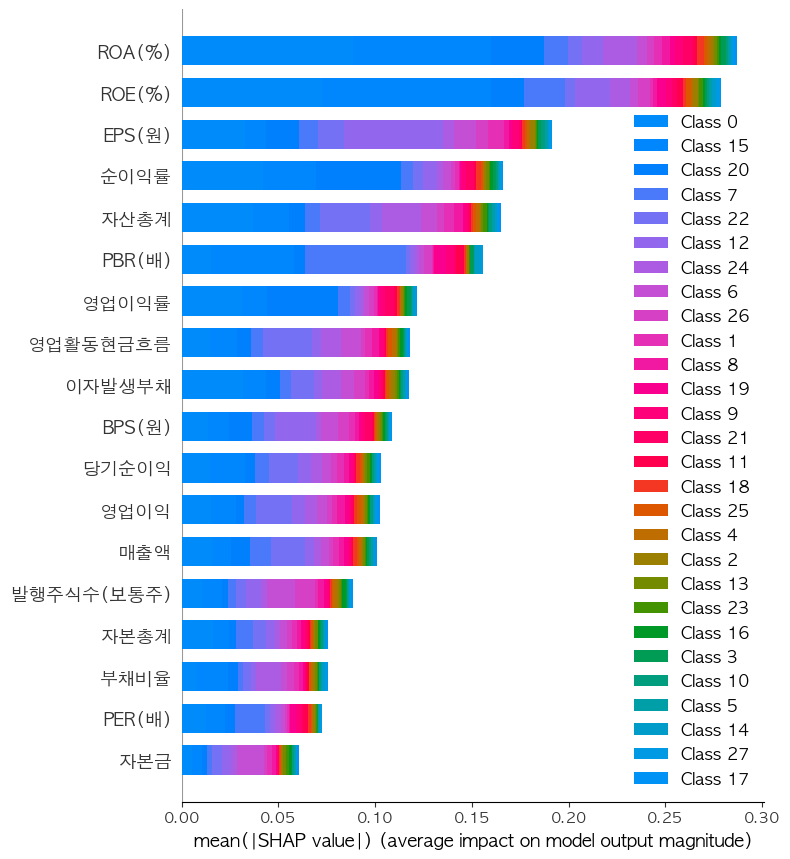

In [40]:
# SHAP 분석
explainer_2021_2023 = shap.TreeExplainer(clf)
shap_values_2021_2023 = explainer_2021_2023.shap_values(X_scaled_df_2021_2023)

# feature importance를 시각화함
shap.summary_plot(shap_values_2021_2023, X_raw_2021_2023, plot_type="bar")

In [41]:
# 클러스터별 SHAP 값의 평균 구하기
cluster_shap_means_2021_2023 = {}
for cluster_id in range(kmeans.n_clusters):
    # 현재 클러스터에 속한 인덱스 추출
    cluster_indices = np.where(kmeans_labels_2021_2023 == cluster_id)[0]
    
    # 해당 클러스터에 대한 SHAP 값만 선택
    cluster_shap_values = shap_values_2021_2023[cluster_indices]
    
    # SHAP 값의 절대값 평균 계산
    cluster_mean_shap = np.abs(cluster_shap_values).mean(axis=0)
    
    # 2차원 배열인 경우 1차원으로 변환 (첫 번째 차원만 사용하거나 적절히 처리)
    if len(cluster_mean_shap.shape) > 1:
        # 차원이 (14, 4)와 같이 2차원인 경우, 첫 번째 차원만 사용하거나 평탄화
        cluster_mean_shap = cluster_mean_shap.flatten() if cluster_mean_shap.size == len(X_raw_2021_2023.columns) else cluster_mean_shap[:, 0]
    
    # 결과 저장
    cluster_shap_means_2021_2023[cluster_id] = cluster_mean_shap

# 모든 클래스에 대한 특성 중요도를 DataFrame으로 변환
feature_importance_df = pd.DataFrame(index=X_raw_2021_2023.columns)

# 각 클래스별 중요도 추가
for cluster_id in range(kmeans.n_clusters):
    # cluster_shap_means[cluster_id]의 길이가 X_raw.columns와 일치하는지 확인
    if len(cluster_shap_means_2021_2023[cluster_id]) != len(X_raw_2021_2023.columns):
        print(f"경고: 클러스터 {cluster_id}의 SHAP 값 길이({len(cluster_shap_means_2021_2023[cluster_id])})가 특성 수({len(X_raw_2021_2023.columns)})와 일치하지 않습니다.")
        continue
    
    feature_importance_df[f'Class {cluster_id}'] = cluster_shap_means_2021_2023[cluster_id]

# 결과 출력 - 각 클래스별로 내림차순 정렬해서 보여주기
print("각 클래스별 특성 중요도 (SHAP 값 평균):")
print(feature_importance_df)

# 각 클래스별로 중요 특성 순위 확인
for cluster_id in range(kmeans.n_clusters):
    if f'Class {cluster_id}' not in feature_importance_df.columns:
        print(f"\nClass {cluster_id}에 대한 특성 중요도를 계산할 수 없습니다.")
        continue
        
    print(f"\nClass {cluster_id}에 중요한 특성 순위:")
    class_importance = feature_importance_df[f'Class {cluster_id}'].sort_values(ascending=False)
    for i, (feature, importance) in enumerate(class_importance.items(), 1):
        print(f"{i}. {feature}: {importance:.6f}")

각 클래스별 특성 중요도 (SHAP 값 평균):
             Class 0   Class 1   Class 2   Class 3   Class 4   Class 5  \
매출액         0.023299  0.018297  0.002758  0.033772  0.012491  0.006665   
영업이익        0.022602  0.034124  0.000738  0.002191  0.029173  0.001857   
당기순이익       0.022321  0.042177  0.004906  0.007482  0.022887  0.003779   
자산총계        0.050012  0.077884  0.015528  0.000732  0.067076  0.037088   
자본총계        0.021096  0.034454  0.007101  0.001087  0.026001  0.021437   
자본금         0.009007  0.001514  0.001217  0.001893  0.013948  0.010218   
영업활동현금흐름    0.019584  0.037944  0.001949  0.005629  0.027880  0.006027   
이자발생부채      0.043322  0.038073  0.013028  0.005505  0.050358  0.028791   
영업이익률       0.045452  0.011883  0.006417  0.063489  0.012548  0.005199   
순이익률        0.060072  0.020339  0.021629  0.098480  0.013117  0.003740   
ROE(%)      0.093506  0.018734  0.080483  0.020190  0.033208  0.064217   
ROA(%)      0.126845  0.048355  0.069035  0.060212  0.050974  0.068352   
부채비율       

### 위에 결과를 보면 각 class 별로 잘 주요한 feature가 나온 것을 확인할 수 있다.

### K-means 클러스터링 결과에 종목명을 포함해서 시각화

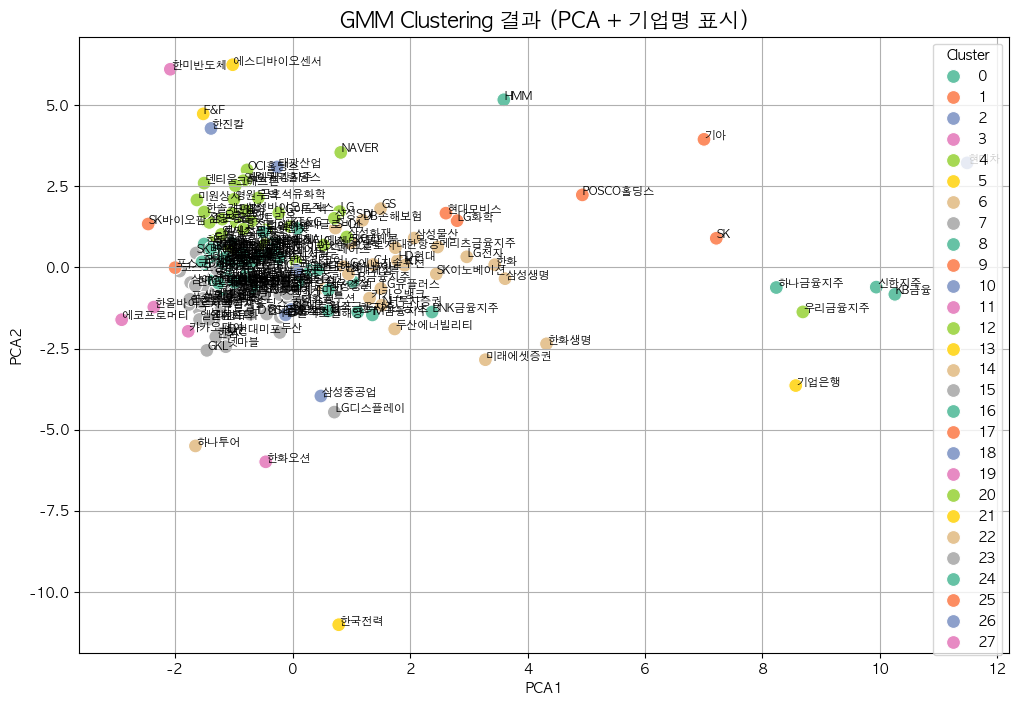

In [42]:
# 시각화를 위해 PCA로 차원을 축소한다.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_2021_2023)

# 결과를 dataFrame으로 정리한다. 
df_clustered = pd.DataFrame({
    '기업명': company_2021_2023.values,
    'Cluster': kmeans_labels_2021_2023,
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1]
})

# 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clustered, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
for i in range(df_clustered.shape[0]):
    plt.text(df_clustered['PCA1'][i]+0.01, df_clustered['PCA2'][i]+0.01, df_clustered['기업명'][i], fontsize=8)
plt.title("GMM Clustering 결과 (PCA + 기업명 표시)", fontsize=15)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

### ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

### 최적의 K 찾기 (2022-2024) - 그래프

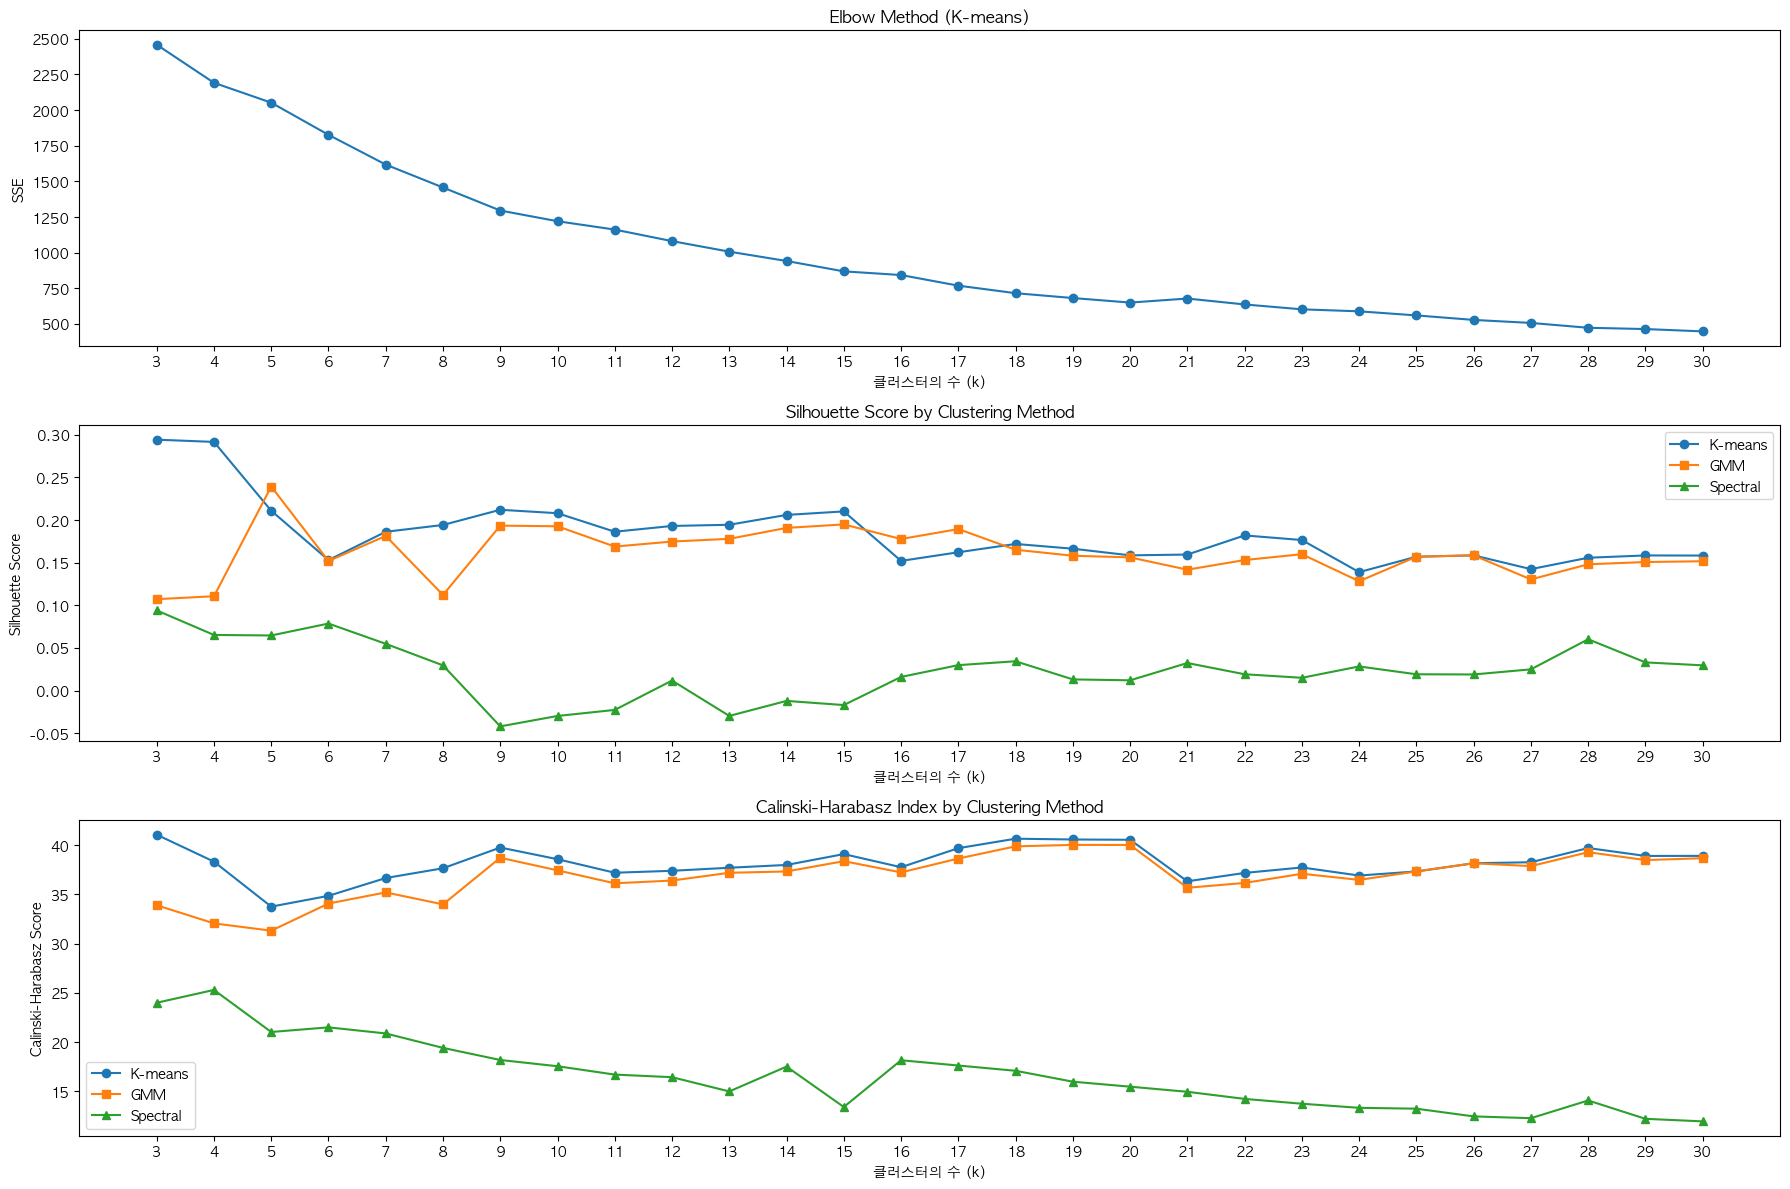

In [44]:
# 후보 K 값 범위 설정
k_values = range(3, 31)

# 결과 저장용 리스트
sse_list = [] # Elbow가 꺽이는 지점 확인용
silhouette_scores = [] # 실루엣 점수가 최대인 지점 확인용
ch_scores = [] # Calinski-Harabasz 점수가 최대인 지점 확인용

gmm_silhouette_scores = []
gmm_ch_scores = []

spectral_silhouette_scores = []
spectral_ch_scores = []

# 각 K에 대해 KMeans, GMM, Spectral 평가 (2020-2022)
for k in k_values:
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels_2022_2024 = kmeans.fit_predict(X_scaled_df_2022_2024)
    
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled_df_2022_2024, kmeans_labels_2022_2024))
    ch_scores.append(calinski_harabasz_score(X_scaled_df_2022_2024, kmeans_labels_2022_2024))
    
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels_2022_2024 = gmm.fit_predict(X_scaled_df_2022_2024)
    gmm_silhouette_scores.append(silhouette_score(X_scaled_df_2022_2024, gmm_labels_2022_2024))
    gmm_ch_scores.append(calinski_harabasz_score(X_scaled_df_2022_2024, gmm_labels_2022_2024))
    
    # Spectral clustering
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')
    spectral_labels_2022_2024 = spectral.fit_predict(X_scaled_df_2022_2024)
    spectral_silhouette_scores.append(silhouette_score(X_scaled_df_2022_2024, spectral_labels_2022_2024))
    spectral_ch_scores.append(calinski_harabasz_score(X_scaled_df_2022_2024, spectral_labels_2022_2024))

plt.figure(figsize=(18, 12))

# SSE (K-means 전용)
plt.subplot(3, 1, 1)
plt.plot(k_values, sse_list, marker='o')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Elbow Method (K-means)")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("SSE")

# Silhouette Score
plt.subplot(3, 1, 2)
plt.plot(k_values, silhouette_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_silhouette_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_silhouette_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Silhouette Score by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Silhouette Score")
plt.legend()

# Calinski-Harabasz Index
plt.subplot(3, 1, 3)
plt.plot(k_values, ch_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_ch_scores, marker='s', label='GMM')
plt.plot(k_values, spectral_ch_scores, marker='^', label='Spectral')
plt.xticks(k_values)  # 모든 k값을 x축에 표시함
plt.title("Calinski-Harabasz Index by Clustering Method")
plt.xlabel("클러스터의 수 (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.legend()

plt.tight_layout()
plt.show()


### 최적의 K 찾기 (2022-2024) - 자동화

Best K for KMeans (lowest DBI): 3 -> DBI = 1.4995
Best K for GMM (lowest DBI): 23 -> DBI = 0.8082
Best K for Spectral Clustering (lowest DBI): 28 -> DBI = 1.3121


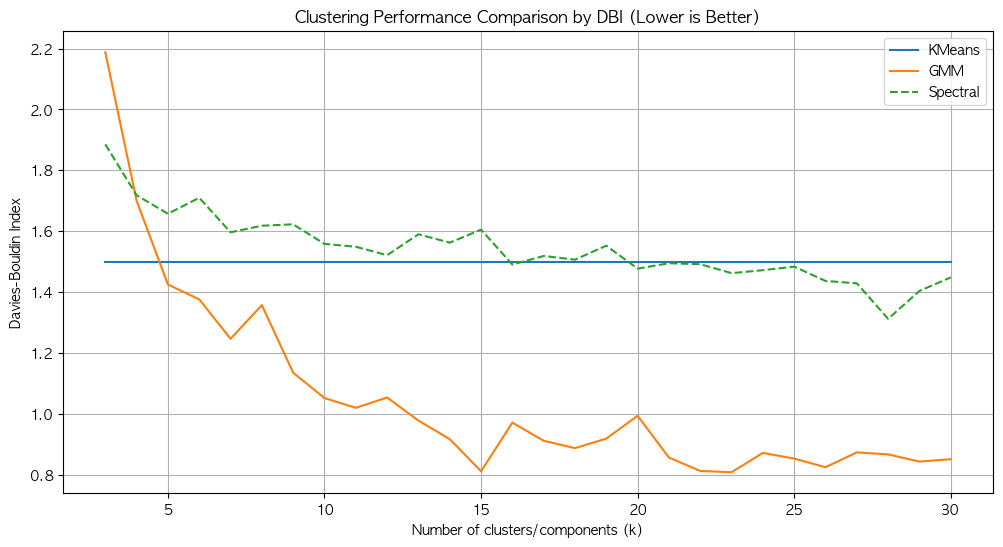

In [47]:
# 결과 저장
k_range = range(3, 31)

dbi_kmeans, dbi_gmm, dbi_spectral = [], [], []

labels_kmeans_all, labels_gmm_all, labels_spectral_all = {}, {}, {}

# 반복 수행
for k in k_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_labels_2023_2024 = kmeans.fit_predict(X_scaled_2022_2024)
    dbi_kmeans.append(davies_bouldin_score(X_scaled_df_2022_2024, kmeans_labels_2022_2024))
    labels_kmeans_all[k] = kmeans_labels_2022_2024

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels_2022_2024 = gmm.fit_predict(X_scaled_df_2022_2024)
    dbi_gmm.append(davies_bouldin_score(X_scaled_df_2022_2024, gmm_labels_2022_2024))
    labels_gmm_all[k] = gmm_labels_2022_2024

    # Spectral Clustering
    try:
        spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors', assign_labels='kmeans')
        spectral_labels_2022_2024 = spectral.fit_predict(X_scaled_df_2022_2024)
        dbi_spectral.append(davies_bouldin_score(X_scaled_df_2022_2024, spectral_labels_2022_2024))
        labels_spectral_all[k] = spectral_labels_2022_2024

    except Exception:
        # 실패한 경우 큰 값으로 대체 (e.g., affinity 문제 등)
        dbi_spectral.append(np.inf)
        labels_spectral_all[k] = None


# 가장 낮은 DBI를 보이는 k 찾기
best_k_kmeans = k_range[np.argmin(dbi_kmeans)]
best_k_gmm = k_range[np.argmin(dbi_gmm)]
best_k_spectral = k_range[np.argmin(dbi_spectral)]

# 결과 출력
print(f"Best K for KMeans (lowest DBI): {best_k_kmeans} -> DBI = {min(dbi_kmeans):.4f}")
print(f"Best K for GMM (lowest DBI): {best_k_gmm} -> DBI = {min(dbi_gmm):.4f}")
print(f"Best K for Spectral Clustering (lowest DBI): {best_k_spectral} -> DBI = {min(dbi_spectral):.4f}")

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(k_range, dbi_kmeans, label='KMeans')
plt.plot(k_range, dbi_gmm, label='GMM')
plt.plot(k_range, dbi_spectral, label='Spectral', linestyle='--')
plt.xlabel('Number of clusters/components (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Clustering Performance Comparison by DBI (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()


### K-means, GMM, Sperctral Clustering 적용 및 비교

In [ ]:
# Window 2021-2023

# K-means clustering
# K-means는 k=3에서 가장 높은 점수를 보임
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels_2022_2024, kmeans_score_2022_2024 = evaluate_clustering(kmeans, X_scaled_df_2022_2024)

# GMM
# GMM은 k=23에서 가장 높은 점수를 보임
gmm = GaussianMixture(n_components=23, random_state=42)
gmm_labels_2022_2024, gmm_score_2022_2024 = evaluate_clustering(gmm, X_scaled_df_2022_2024, labels=gmm.fit_predict(X_scaled_df_2022_2024))

# Spectral clustering
# Spectral clustering은 거의 모든 k의 범위에서 평가가 낮게 나옴
spectral = SpectralClustering(n_clusters=28, random_state=42, affinity='nearest_neighbors')
spectral_labels_2022_2024, spectral_score_2022_2024 = evaluate_clustering(spectral, X_scaled_df_2022_2024)


# Davies-Bouldin Index 계산
# 보통 0.5 ~ 1.0 사이면 괜찮은 클러스터링이라고 함. 실무에서 자주 나오는 수준
kmeans_dbi_2022_2024 = davies_bouldin_score(X_scaled_df_2022_2024, kmeans_labels_2022_2024)
gmm_dbi_2022_2024 = davies_bouldin_score(X_scaled_df_2022_2024, gmm_labels_2022_2024)
spectral_dbi_2022_2024 = davies_bouldin_score(X_scaled_df_2022_2024, spectral_labels_2022_2024)

# 결과 비교 출력
print(f"KMeans Davies-Bouldin Index: {kmeans_dbi_2022_2024:.4f}")
print(f"GMM Davies-Bouldin Index: {gmm_dbi_2022_2024:.4f}")
print(f"Spectral Davies-Bouldin Index: {spectral_dbi_2022_2024:.4f}")

# # 결과 비교
# print(f"KMeans Silhouette Score: {kmeans_score:.4f}")
# print(f"GMM Silhouette Score: {gmm_score:.4f}")
# print(f"Spectral Silhouette Score: {spectral_score:.4f}")


KMeans Davies-Bouldin Index: 1.4995
GMM Davies-Bouldin Index: 0.8082
Spectral Davies-Bouldin Index: 1.3121


### 최종적으로 선택한 클러스터 결과 저장 (K-means)

In [51]:
# GMM이 0.8082로 값이 가장 낮게 나왔다.
df_2022_2024['Cluster'] = gmm_labels_2022_2024

### Random Forest 학습 - XAI 해석용

In [52]:
# RandomForestClassifier 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators은 기본값으로 사용함
clf.fit(X_scaled_df_2022_2024, gmm_labels_2022_2024)

RandomForestClassifier(random_state=42)

### SHAP 해석

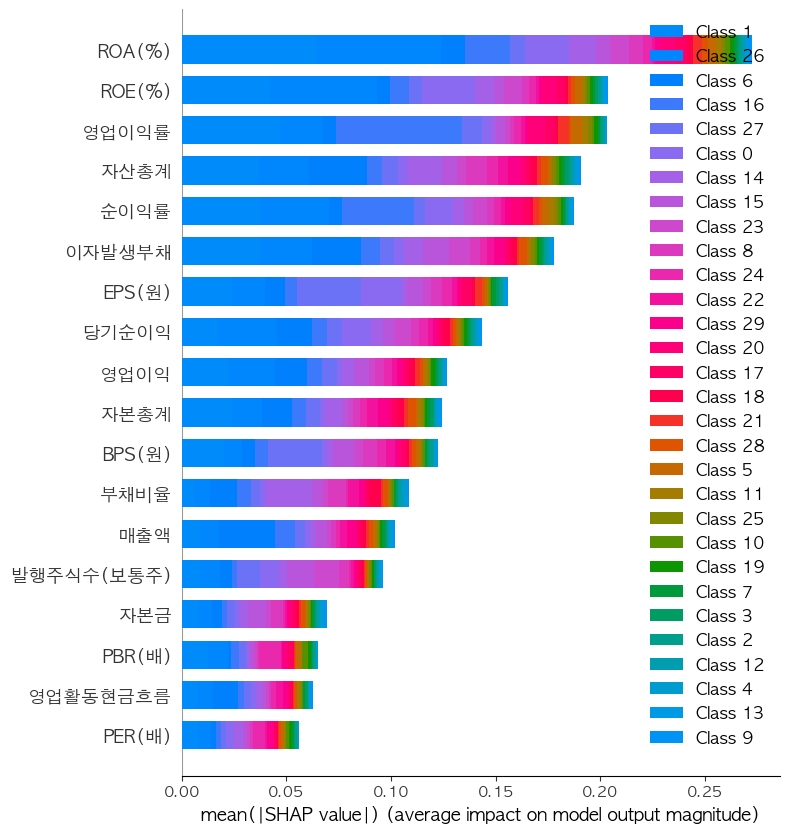

In [53]:
# SHAP 분석
explainer_2022_2024 = shap.TreeExplainer(clf)
gmm_values_2022_2024 = explainer_2022_2024.shap_values(X_scaled_df_2022_2024)

# feature importance를 시각화함
shap.summary_plot(gmm_values_2022_2024, X_raw_2022_2024, plot_type="bar")

In [56]:
# 클러스터별 SHAP 값의 평균 구하기
cluster_gmm_means_2022_2024 = {}
for cluster_id in range(gmm.n_components):
    # 현재 클러스터에 속한 인덱스 추출
    cluster_indices = np.where(gmm_labels_2022_2024 == cluster_id)[0]
    
    # 해당 클러스터에 대한 SHAP 값만 선택
    cluster_shap_values = gmm_values_2022_2024[cluster_indices]
    
    # SHAP 값의 절대값 평균 계산
    cluster_mean_shap = np.abs(cluster_shap_values).mean(axis=0)
    
    # 2차원 배열인 경우 1차원으로 변환 (첫 번째 차원만 사용하거나 적절히 처리)
    if len(cluster_mean_shap.shape) > 1:
        # 차원이 (14, 4)와 같이 2차원인 경우, 첫 번째 차원만 사용하거나 평탄화
        cluster_mean_shap = cluster_mean_shap.flatten() if cluster_mean_shap.size == len(X_raw_2022_2024.columns) else cluster_mean_shap[:, 0]
    
    # 결과 저장
    cluster_gmm_means_2022_2024[cluster_id] = cluster_mean_shap

# 모든 클래스에 대한 특성 중요도를 DataFrame으로 변환
feature_importance_df = pd.DataFrame(index=X_raw_2022_2024.columns)

# 각 클래스별 중요도 추가
for cluster_id in range(gmm.n_components):
    # cluster_shap_means[cluster_id]의 길이가 X_raw.columns와 일치하는지 확인
    if len(cluster_gmm_means_2022_2024[cluster_id]) != len(X_raw_2022_2024.columns):
        print(f"경고: 클러스터 {cluster_id}의 SHAP 값 길이({len(cluster_gmm_means_2022_2024[cluster_id])})가 특성 수({len(X_raw_2022_2024.columns)})와 일치하지 않습니다.")
        continue
    
    feature_importance_df[f'Class {cluster_id}'] = cluster_gmm_means_2022_2024[cluster_id]

# 결과 출력 - 각 클래스별로 내림차순 정렬해서 보여주기
print("각 클래스별 특성 중요도 (SHAP 값 평균):")
print(feature_importance_df)

# 각 클래스별로 중요 특성 순위 확인
for cluster_id in range(gmm.n_components):
    if f'Class {cluster_id}' not in feature_importance_df.columns:
        print(f"\nClass {cluster_id}에 대한 특성 중요도를 계산할 수 없습니다.")
        continue
        
    print(f"\nClass {cluster_id}에 중요한 특성 순위:")
    class_importance = feature_importance_df[f'Class {cluster_id}'].sort_values(ascending=False)
    for i, (feature, importance) in enumerate(class_importance.items(), 1):
        print(f"{i}. {feature}: {importance:.6f}")

각 클래스별 특성 중요도 (SHAP 값 평균):
             Class 0   Class 1   Class 2   Class 3   Class 4   Class 5  \
매출액         0.012145  0.000523  0.000504  0.014231  0.000261  0.000494   
영업이익        0.020008  0.000622  0.005919  0.004937  0.001854  0.000705   
당기순이익       0.087261  0.005883  0.006846  0.030358  0.007118  0.005123   
자산총계        0.027534  0.001433  0.003999  0.011493  0.001832  0.000648   
자본총계        0.015895  0.000515  0.003321  0.011514  0.000960  0.000096   
자본금         0.012293  0.001242  0.001112  0.001736  0.002581  0.000923   
영업활동현금흐름    0.012774  0.000626  0.001337  0.025904  0.000164  0.000027   
이자발생부채      0.020110  0.003366  0.001022  0.007106  0.000421  0.002365   
영업이익률       0.027402  0.001396  0.005797  0.000128  0.000755  0.005187   
순이익률        0.079849  0.007867  0.012825  0.007069  0.008393  0.008838   
ROE(%)      0.146104  0.016649  0.012733  0.054289  0.012893  0.014898   
ROA(%)      0.141192  0.016466  0.018089  0.007185  0.001716  0.017084   
부채비율       

### 위에 결과를 보면 각 class 별로 잘 주요한 feature가 나온 것을 확인할 수 있다.

### K-means 클러스터링 결과에 종목명을 포함해서 시각화

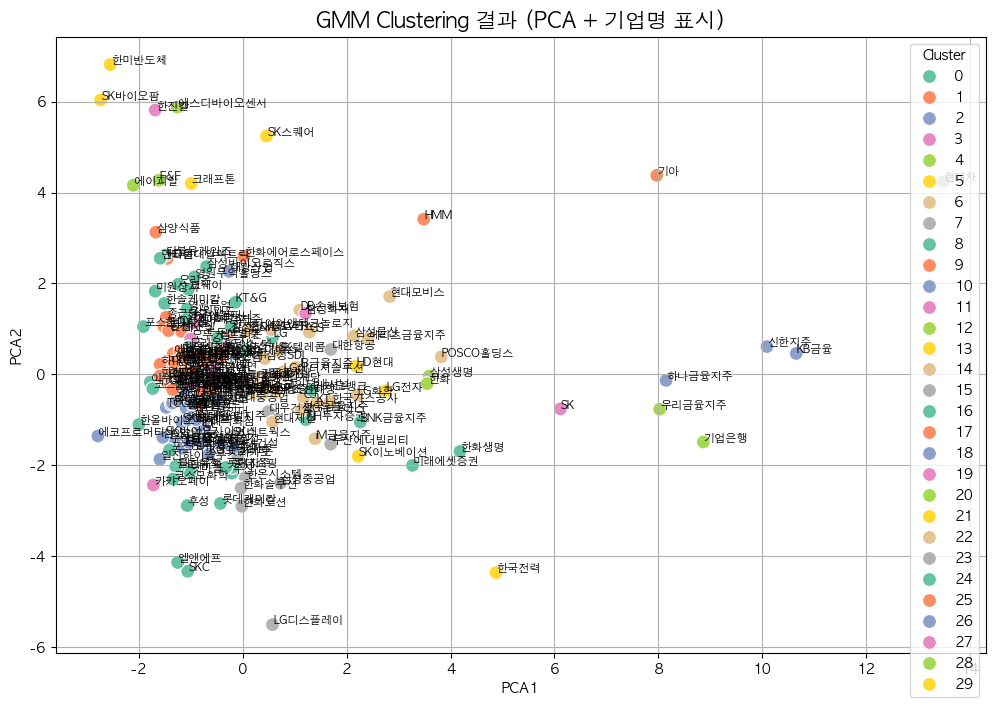

In [58]:
# 시각화를 위해 PCA로 차원을 축소한다.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_2022_2024)

# 결과를 dataFrame으로 정리한다. 
df_clustered = pd.DataFrame({
    '기업명': company_2022_2024.values,
    'Cluster': gmm_labels_2022_2024,
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1]
})

# 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clustered, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
for i in range(df_clustered.shape[0]):
    plt.text(df_clustered['PCA1'][i]+0.01, df_clustered['PCA2'][i]+0.01, df_clustered['기업명'][i], fontsize=8)
plt.title("GMM Clustering 결과 (PCA + 기업명 표시)", fontsize=15)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()